# Imports

In [207]:
# imports
import pennylane as qml
import numpy as np
import torch
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

# Model Definition

In [208]:
# feature layer
def feature_layer(x):
    num_qubits = len(x)
    qml.IQPEmbedding(x, wires=range(num_qubits))

In [209]:
# variational layer
def variational_layer(init_theta, theta, num_qubits):
    qml.SimplifiedTwoDesign(initial_layer_weights=init_theta, weights=theta, wires=range(num_qubits))

In [210]:
# observable / output layer
def sequence_generator(n):
    if n == 0:
        return [[]]
    else:
        sequences = []
        for sequence in sequence_generator(n-1):
            sequences.append(sequence + [n-1])
            sequences.append(sequence)
        return sequences
    
def parities(n):
    
    seq = sequence_generator(n)
    ops = []
    for par in seq:
        if par:
            tmp = qml.PauliZ(par[0])
            if len(par) > 1:
                for i in par[1:]:
                    tmp = tmp @ qml.PauliZ(i)

            ops.append(tmp)

    ops.append(qml.Identity(0))

    return ops

In [211]:
# device
num_qubits = 3
shots      = None
dev        = qml.device('default.qubit', wires=num_qubits, shots=shots)

In [212]:
# QNN model
@qml.qnode(dev, interface='torch')
def qnn_model(x, init_theta, theta, W, omega=0.):

    num_qubits = len(x)
    shape_init = init_theta.shape
    reps       = 1
    if len(shape_init) < 1:
        init_theta = [init_theta]
        shape_init = init_theta.shape
        reps       = shape_init[0]

    shape_theta = theta.shape
    reps_       = 1
    if len(shape_theta) < 3:
        theta       = [theta]
        shape_theta = theta.shape
        reps_       = shape_theta[0]

    assert reps == reps_

    for l in range(reps):
        feature_layer(2**(omega*l)*x)
        variational_layer(init_theta[l], theta[l], num_qubits)
    
    num_qubits = len(x)
    for l in range(reps):
        feature_layer(x)
        variational_layer(init_theta[l], theta[l], num_qubits)

    obs = parities(num_qubits)
    H   = qml.Hamiltonian(W, obs)

    return qml.expval(H)

(<Figure size 700x400 with 1 Axes>, <Axes: >)


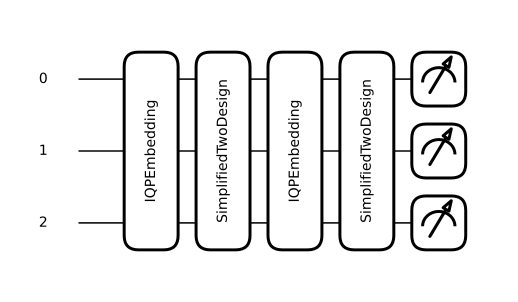

In [213]:
# example
num_qubits  = 3
num_reps    = 2
num_layers  = 2
omega       = 1.
x           = torch.randn(num_qubits, requires_grad=False)
init_theta  = torch.randn(num_reps, num_qubits, requires_grad=True)
theta       = torch.randn(num_reps, num_layers, num_qubits-1, 2, requires_grad=True)
W           = torch.randn(2**num_qubits, requires_grad=True)

print(qml.draw_mpl(qnn_model)(x, init_theta, theta, W, omega))

# Datasets for Capacity Estimation

In [214]:
N       = 2
samples = 10
seed    = 0
sizex   = num_qubits
scale   = 2.
shift   = -1.

torch.manual_seed(seed)
x       = scale*torch.rand(N, sizex, requires_grad=False) + shift
y       = scale*torch.rand(samples, N, requires_grad=False) + shift

# Training

In [215]:
# model specs
num_qubits  = 3
num_reps    = 2
num_layers  = 2
omega       = 1.

In [216]:
# loss function
def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

In [217]:
# total cost for this model and data sample
s = 0
def cost(init_theta, theta, W):
    pred = [qnn_model(x[k], init_theta, theta, W) for k in range(N)]
    loss = square_loss(y[s], pred)
    return loss

In [218]:
# initial parameters
seed = 0
torch.manual_seed(seed)
init_theta  = torch.randn(num_reps, num_qubits, requires_grad=True)
theta       = torch.randn(num_reps, num_layers, num_qubits-1, 2, requires_grad=True)
W           = torch.randn(2**num_qubits, requires_grad=True)

In [219]:
# optimize
steps = 100
opt   = torch.optim.Adam([init_theta, theta, W], lr=0.1)

for n in range(steps):
    opt.zero_grad()
    loss = cost(init_theta, theta, W)
    loss.backward()
    opt.step()

    if n%10 == 9 or n == steps - 1:
        print(f'{n+1}: {loss}')

10: 0.001957429948487292
20: 0.014326998052355306
30: 0.0067581865792884855
40: 0.002001678550491869
50: 0.00017160572221130603
60: 4.932047629286499e-05
70: 0.00011458465207127944
80: 1.5955636312725904e-05
90: 4.869795250914098e-06
100: 4.691201781115825e-06


# Summary

In [220]:
y_pred = torch.tensor([qnn_model(x[k], init_theta, theta, W) for k in range(N)], requires_grad=False)
mre    = torch.mean(torch.abs((y[s]-y_pred)/y_pred))
print(mre.item())

0.07519176977829169


In [193]:
# cutoff precision converted to bits of precision
cutoff = 1e-06
m      = np.log2(1./cutoff)
print(m)

19.931568569324174


In [190]:
print(x)
print(init_theta)
print(theta)
print(W)
print(y[s])
print(y_pred)

tensor([[-0.0075,  0.5364, -0.8230],
        [-0.7359, -0.3852,  0.2682]])
tensor([[ 1.7521, -0.4783, -2.4607],
        [ 0.5684, -1.0845, -1.3986]], requires_grad=True)
tensor([[[[ 0.4618,  0.8843],
          [-0.1434,  0.2924]],

         [[-1.7403, -1.3550],
          [ 1.0728,  0.8781]]],


        [[[-0.1932, -0.3090],
          [ 0.5026, -0.8594]],

         [[ 0.7502, -0.5855],
          [-0.1734,  0.1835]]]], requires_grad=True)
tensor([-0.4655, -0.1970,  0.5429,  0.1071,  0.3934, -1.5256,  0.7002,  1.0703],
       requires_grad=True)
tensor([-0.0198,  0.7929])
tensor([-0.0198,  0.7929], dtype=torch.float64)
